## UVA SDS Capstone

## Stephanie Verbout, Landon Blakey, Shashank Sharma, Hayley Kisiel

### This notebook contains code that runs 4 times repeated 4-fold cross-validation on our data set.

### Dataset was created from the RecordUpdated.ipynb notebook

In [1]:
# import libraries

import os
import glob
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.datasets import load_files 
from keras.utils import np_utils
from tensorflow import keras
from keras.preprocessing import image
from tensorflow.keras import layers
import numpy as np
from sklearn.model_selection import KFold
from sklearn.model_selection import RepeatedKFold

#!pip install tqdm
from tqdm import tqdm # progress bar

In [2]:
# Resets notebook state
tf.keras.backend.clear_session()

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print(
    "GPU is",
    "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
GPU is available


In [3]:
# set seeds for reproducibility
np.random.seed(142) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(142)

In [4]:
# set up image directory and sizes
data_dir = "../common/images/"

In [5]:
# set batch size, images size, and define class names
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 299; 
img_width = 299;
class_names = ['ACC','DEC_EARLY','DEC_LATE','DEC_VAR','NONE']

In [6]:
# build the datasets
# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    validation_split = 0.11,
    subset = "training",
    seed = 142,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
holdout_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='int',
    class_names=class_names,
    validation_split = 0.11,
    subset = "validation",
    seed = 142,
    image_size = (img_height, img_width),
    batch_size = batch_size
)

Found 2398 files belonging to 5 classes.
Using 2135 files for training.
Found 2398 files belonging to 5 classes.
Using 263 files for validation.


2022-05-11 13:36:34.075780: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-05-11 13:36:35.898454: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 38397 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-40GB, pci bus id: 0000:90:00.0, compute capability: 8.0


In [7]:
# verify correct class names
train_ds.class_names

['ACC', 'DEC_EARLY', 'DEC_LATE', 'DEC_VAR', 'NONE']

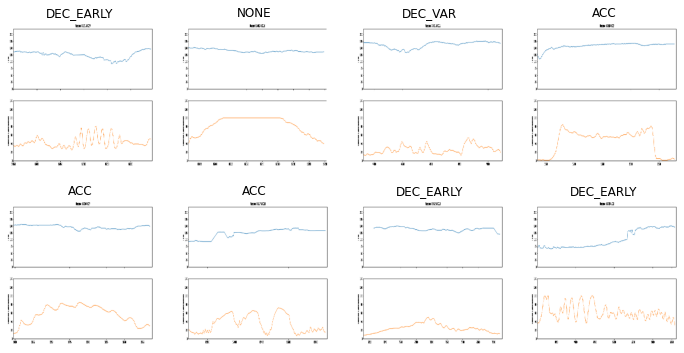

In [8]:
# display some example images
class_names = ['ACC','DEC_EARLY','DEC_LATE','DEC_VAR','NONE']
NUM_CLASSES = len(class_names)

# Rows and columns are set to fit one training batch (32)
n_rows = 2
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

In [9]:
# extract labels for each dataset
train_label = np.concatenate([y for x, y in train_ds], axis=0)
holdout_label = np.concatenate([y for x, y in holdout_ds], axis=0)

In [10]:
# count instances of each class in each dataset
count_train = np.bincount(train_label).tolist()
count_holdout = np.bincount(holdout_label).tolist()

In [11]:
# function to plot the distribution of each dataset
def plot_distributions(x_data, y_data, title, ylimit, color):
    # the freq of the data
    plt.rcParams["figure.figsize"] = (10,5)
    df = pd.DataFrame({'x_data':x_data,'y_data':y_data})
    df.sort_values('y_data', inplace=True)
    
    df.plot(kind='bar', y='y_data', x='x_data', color=color)
    plt.legend('')    #shows no legend
    plt.xlabel('Classification')
    plt.xticks(rotation = 45)
    plt.ylabel('Frequency')
    plt.title(title)
    plt.ylim(0, ylimit)
    
    plt.show()

In [16]:
# can show each dataset counts separately here if wanted
#plot_distributions(class_names,count_train,'Frequency of Each Class: Training Data', 700, 'r')

In [17]:
#plot_distributions(class_names,count_val,'Frequency of Each Class: Validation Data', 400, 'g')

In [18]:
#plot_distributions(class_names,count_test,'Frequency of Each Class: Test Data', 70, 'b')

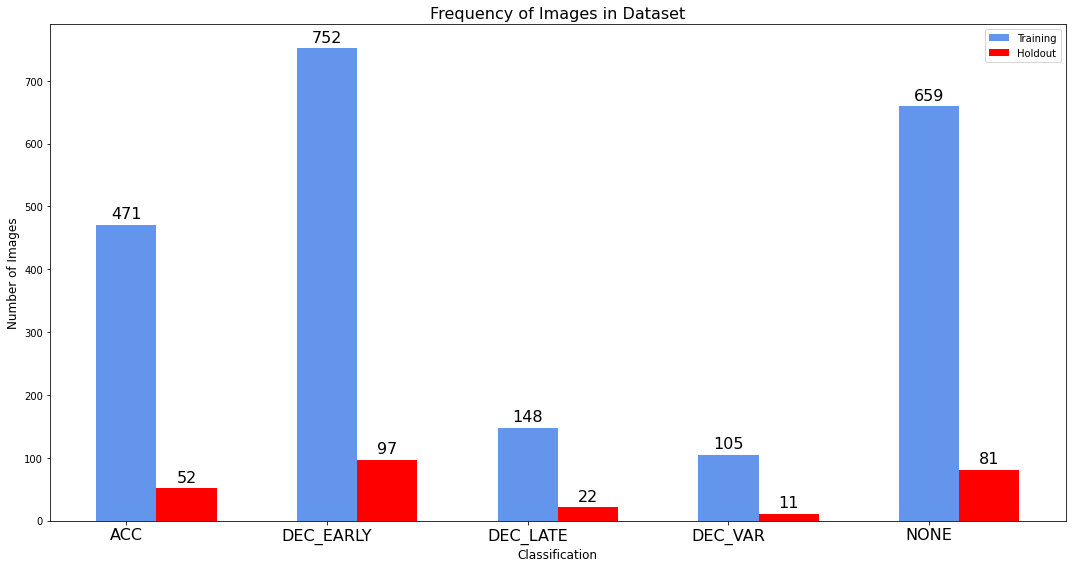

In [21]:
# plot dataset distributions
X_axis = np.arange(len(class_names))
plot_labels = ['ACC', 'DEC_EARLY', 'DEC_LATE', 'DEC_VAR', 'NONE']
width = 0.3

plt.rcParams["figure.figsize"] = (15,8)
fig, ax = plt.subplots()
rects1 = ax.bar(X_axis, count_train, 0.3, label = 'Training', color='cornflowerblue')
rects2 = ax.bar(X_axis+width, count_holdout, 0.3, label = 'Holdout', color='r')

# Add some text for labels, title and custom x-axis tick labels
ax.set_xticks(X_axis)
ax.set_xticklabels(plot_labels, fontsize=16)
ax.set_xlabel("Classification", fontsize=12)
ax.set_ylabel("Number of Images", fontsize=12)
ax.set_title("Frequency of Images in Dataset", fontsize=16)
ax.legend()
# show the numbers for each bar
ax.bar_label(rects1, padding=3, fontsize=16)
ax.bar_label(rects2, padding=3, fontsize=16)

fig.tight_layout()

plt.show()

In [22]:
# Resets notebook state
tf.keras.backend.clear_session()

# ADAPTED CTGNet

In [23]:
# define function to build the Adapted CTGNet

def build_AdaptedCTGNet_model(trainable_layers=15, verbose=False):

    # for Adapted CTGNet, all layers are trainable
    model = keras.models.Sequential([
            keras.layers.InputLayer(input_shape=[299,299,3],   
                                    dtype='float32',
                                    input_tensor=None,
                                    sparse=False,
                                    name='input_1',
                                    ragged=None,
                                    type_spec=None),
            keras.layers.Conv2D(filters=4,                        # batch_input_shape = [1, 2, 1800]
                                kernel_size=(1,30),
                                strides=(1, 1),
                                padding='same',
                                data_format='channels_last',
                                dilation_rate=(1, 1),
                                groups=1,
                                activation='linear',
                                use_bias=False,
                                kernel_initializer='he_normal',
                                bias_initializer='zeros',
                                kernel_regularizer=None,
                                bias_regularizer=None,
                                activity_regularizer=None,
                                kernel_constraint=None,
                                bias_constraint=None,
                                trainable=True,
                                name='conv2d'),
            keras.layers.BatchNormalization(axis=3,
                                            momentum=0.99,
                                            epsilon=0.001,
                                            center=True,scale=True,
                                            trainable=True,
                                            name='batch_normalization'),
            keras.layers.DepthwiseConv2D(kernel_size = (2, 1),
                                         strides=(1, 1),
                                         padding='valid',
                                         depth_multiplier=2,
                                         data_format='channels_last',
                                         dilation_rate=(1, 1),
                                         activation='linear',
                                         use_bias=False,
                                         depthwise_initializer='he_normal',
                                         bias_initializer='zeros',
                                         depthwise_regularizer=None,
                                         bias_regularizer=None,
                                         activity_regularizer=None,
                                         depthwise_constraint="MaxNorm",
                                         bias_constraint=None,
                                         trainable=True,
                                         name='depthwise_conv2d'),
            keras.layers.BatchNormalization(axis=3,
                                            momentum=0.99,
                                            epsilon=0.001,
                                            center=True,
                                            scale=True,
                                            trainable=True,
                                            name='batch_normalization_1'),
            keras.layers.Activation('elu', 
                                    trainable=True, 
                                    name='activation'),
            keras.layers.MaxPooling2D(pool_size=(1,4), 
                                      strides=(1,4), 
                                      padding='valid', 
                                      data_format='channels_last',
                                      trainable=True,
                                      name='max_pooling2d'),
            keras.layers.Dropout(0.50, 
                                 trainable=True, 
                                 name='dropout'),
            keras.layers.SeparableConv2D(filters=8,
                                         kernel_size=(1,7),
                                         strides=(1, 1),
                                         padding='same',
                                         data_format='channels_last',
                                         dilation_rate=(1, 1),
                                         depth_multiplier=1,
                                         activation='linear',
                                         use_bias=False,
                                         depthwise_initializer='he_normal',
                                         pointwise_initializer='he_normal',
                                         bias_initializer='zeros',
                                         trainable=True,
                                         name='separable_conv2d'),
            keras.layers.BatchNormalization(axis=3,
                                            momentum=0.99,
                                            epsilon=0.001,
                                            center=True,
                                            scale=True,
                                            trainable=True,
                                            name='batch_normalization_2'),
            keras.layers.Activation('elu', 
                                    trainable=True, 
                                    name='activation_1'),
            keras.layers.MaxPooling2D(pool_size=(1,4), 
                                      strides=(1,4), 
                                      padding='valid', 
                                      data_format='channels_last',
                                      trainable=True,
                                      name='max_pooling2d_1'),
            keras.layers.Dropout(0.50, 
                                 trainable=True, 
                                 name='dropout_1'),
            keras.layers.Flatten(data_format='channels_last', 
                                 trainable=True, 
                                 name='flatten'),
            keras.layers.Dense(units=NUM_CLASSES*150,
                               activation='linear',
                               use_bias=True,
                               kernel_initializer='he_normal',
                               bias_initializer='zeros',
                               kernel_regularizer=tf.keras.regularizers.l2(0.01),
                               bias_regularizer=None,
                               activity_regularizer=None,
                               kernel_constraint='MaxNorm',
                               trainable=True,
                               name='dense1'),
            keras.layers.Dense(units=NUM_CLASSES*75,
                               activation='linear',
                               use_bias=True,
                               kernel_initializer='he_normal',
                               bias_initializer='zeros',
                               kernel_regularizer=tf.keras.regularizers.l2(0.01),
                               bias_regularizer=None,
                               activity_regularizer=None,
                               kernel_constraint='MaxNorm',
                               trainable=True,
                               name='dense2'),
            keras.layers.Dense(units=NUM_CLASSES,
                               activation='softmax',
                               trainable=True,
                               name='softmax_output')   # we need
            ])

    optimizer = keras.optimizers.Adam(learning_rate=1e-4)
     
    # use sparse_categorical_crossentropy as labels are not one-hot encoded
    model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=['sparse_categorical_accuracy'])

    if verbose:
        print(model.summary())
    
    return model

In [24]:
# unbatch the training dataset and make into list
flat_train_ds = train_ds.unbatch()
train_list = list(flat_train_ds.as_numpy_iterator())

In [25]:
# concatenate all training images and labels together
trainImages = []
trainLabels =  []
for x, y in train_list:
    trainImages.append(x)
    trainLabels.append(y)
    
train_images = np.array((trainImages))
train_labels = np.array((trainLabels))

In [26]:
print('train_images shape:', train_images.shape, 'train_labels shape:', train_labels.shape)

train_images shape: (2135, 299, 299, 3) train_labels shape: (2135,)


In [27]:
# make train_labels into list
train_label_list = train_labels.tolist()

# function that counts the number of images in each class in the training data
def countX(lst):
    d = {
        '0': 0,
        '1': 0,
        '2': 0,
        '3': 0,
        '4': 0
    }
    for ele in lst:
        d[str(ele)] += 1
    print( f"\n\
          ACC: {d['0']} \n\
          DEC_EARLY: {d['1']} \n\
          DEC_LATE: {d['2']} \n\
          DEC_VAR: {d['3']} \n\
          NONE: {d['4']}"
         )

# show counts of each class in training data    
countX(train_label_list) 


          ACC: 471 
          DEC_EARLY: 752 
          DEC_LATE: 148 
          DEC_VAR: 105 
          NONE: 659


In [28]:
# for each label in the holdout dataset, write to a list
holdout_label_list =  []
for _, y in holdout_ds.unbatch():
    holdout_label_list.append(y.numpy())

# shows the count of each class in holdout data
countX(holdout_label_list)


          ACC: 52 
          DEC_EARLY: 97 
          DEC_LATE: 22 
          DEC_VAR: 11 
          NONE: 81


In [29]:
# Define per-fold score containers and history list
acc_per_fold = []
loss_per_fold = []
histories = []
models = []
splits = []

# Define the repeated K-fold Cross Validator
rkf = RepeatedKFold(n_splits=4, n_repeats=4, random_state=142)

In [30]:
# fit the model to image data and train
# K-fold Cross Validation model evaluation
fold_no = 1
for train, test in rkf.split(train_images,train_labels):
    
    # build the model with function above
    model = build_AdaptedCTGNet_model()
    
    # fit the training images to the model
    history = model.fit(train_images[train],
                        train_labels[train],
                        validation_data = (train_images[test], train_labels[test]),
                        epochs=40,
                        batch_size = batch_size,
                        callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3),
                                    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                                         factor=0.1,
                                                                         patience=3,
                                                                         verbose=1,
                                                                         mode='auto',
                                                                         min_delta=0.0001,
                                                                         cooldown=0,
                                                                         min_lr=1e-7)],
                        verbose=1
                        )


    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Generate generalization metrics
    scores = model.evaluate(holdout_ds)
    print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
    acc_per_fold.append(scores[1] * 100)
    loss_per_fold.append(scores[0])
    histories.append(history)
    models.append(model)
    splits.append((train, test))
    # save model
    model.save(f'new_split_CTG_model_final_crossValidation{fold_no}')
    
    # Increase fold number
    fold_no = fold_no + 1

Epoch 1/40


2022-05-11 13:44:36.359659: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101
2022-05-11 13:44:41.262471: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


51/51 [==============================] - 16s 154ms/step - loss: 39.8465 - sparse_categorical_accuracy: 0.3248 - val_loss: 46.9158 - val_sparse_categorical_accuracy: 0.0712 - lr: 1.0000e-04
Epoch 2/40
51/51 [==============================] - 7s 145ms/step - loss: 29.8964 - sparse_categorical_accuracy: 0.4022 - val_loss: 26.4994 - val_sparse_categorical_accuracy: 0.4157 - lr: 1.0000e-04
Epoch 3/40
51/51 [==============================] - 7s 145ms/step - loss: 27.7183 - sparse_categorical_accuracy: 0.4060 - val_loss: 29.7728 - val_sparse_categorical_accuracy: 0.2116 - lr: 1.0000e-04
Epoch 4/40
51/51 [==============================] - 7s 145ms/step - loss: 28.9148 - sparse_categorical_accuracy: 0.4029 - val_loss: 25.3059 - val_sparse_categorical_accuracy: 0.4064 - lr: 1.0000e-04
Epoch 5/40
51/51 [==============================] - 7s 146ms/step - loss: 24.0931 - sparse_categorical_accuracy: 0.5066 - val_loss: 23.8113 - val_sparse_categorical_accuracy: 0.4195 - lr: 1.0000e-04
Epoch 6/40
51/5

2022-05-11 13:49:38.354872: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: new_split_CTG_model_final_crossValidation1/assets
Epoch 1/40
51/51 [==============================] - 8s 151ms/step - loss: 31.2920 - sparse_categorical_accuracy: 0.3435 - val_loss: 30.3725 - val_sparse_categorical_accuracy: 0.3090 - lr: 1.0000e-04
Epoch 2/40
51/51 [==============================] - 7s 142ms/step - loss: 27.9457 - sparse_categorical_accuracy: 0.4216 - val_loss: 27.8259 - val_sparse_categorical_accuracy: 0.3801 - lr: 1.0000e-04
Epoch 3/40
51/51 [==============================] - 7s 143ms/step - loss: 25.5612 - sparse_categorical_accuracy: 0.4485 - val_loss: 24.3322 - val_sparse_categorical_accuracy: 0.4007 - lr: 1.0000e-04
Epoch 4/40
51/51 [==============================] - 7s 144ms/step - loss: 24.1606 - sparse_categorical_accuracy: 0.4747 - val_loss: 24.5459 - val_sparse_categorical_accuracy: 0.3446 - lr: 1.0000e-04
Epoch 5/40
51/51 [==============================] - 7s 144ms/step - loss: 24.5898 - sparse_categorical_accuracy: 0.4510

In [31]:
# == Provide average scores ==
print('------------------------------------------------------------------------')
print('Score per fold')

for i in range(0, len(acc_per_fold)):
    print('------------------------------------------------------------------------')
    print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')

print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Score per fold
------------------------------------------------------------------------
> Fold 1 - Loss: 11.66965103149414 - Accuracy: 35.741445422172546%
------------------------------------------------------------------------
> Fold 2 - Loss: 10.178832054138184 - Accuracy: 44.86691951751709%
------------------------------------------------------------------------
> Fold 3 - Loss: 10.320478439331055 - Accuracy: 40.68441092967987%
------------------------------------------------------------------------
> Fold 4 - Loss: 9.831480026245117 - Accuracy: 48.28897416591644%
------------------------------------------------------------------------
> Fold 5 - Loss: 10.126447677612305 - Accuracy: 45.24714946746826%
------------------------------------------------------------------------
> Fold 6 - Loss: 10.196718215942383 - Accuracy: 36.12167239189148%
------------------------------------------------------------------------


In [32]:
# define function to plot the accuracies of training and validation set
def plot_hist(hist):  
    
    plt.rcParams["figure.figsize"] = (12,8)
    plt.plot(hist.history["sparse_categorical_accuracy"])
    plt.plot(hist.history["val_sparse_categorical_accuracy"])
    plt.title("Adapted CTGNet Model Accuracy")
    plt.ylabel("Accuracy")
    plt.xlabel("Epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.ylim(0.0,1.0)
    plt.show()

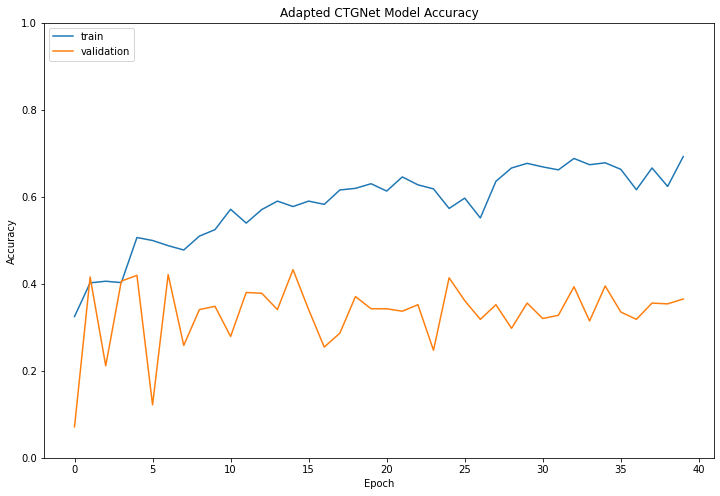

In [33]:
# plot the accuracies and epochs    
plot_hist(histories[0])

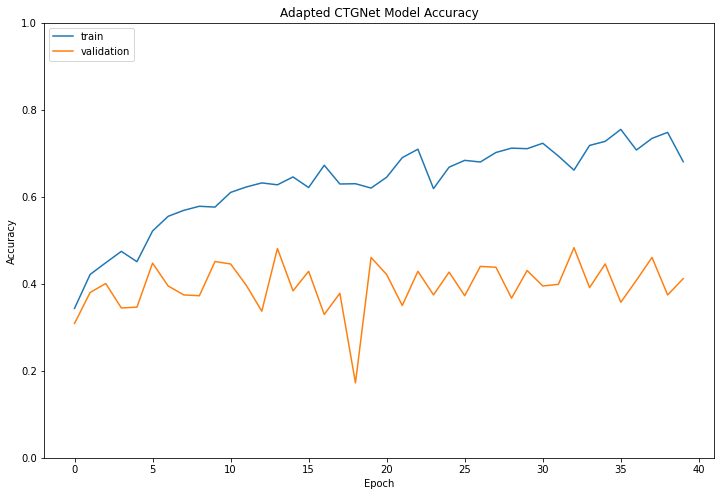

In [34]:
plot_hist(histories[1])

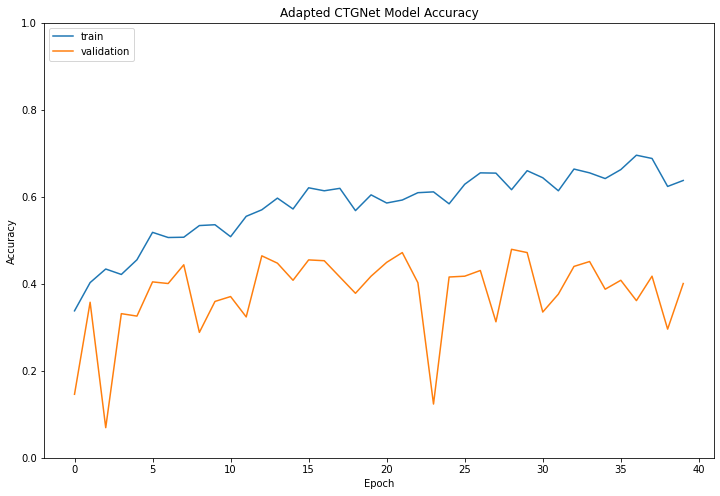

In [35]:
plot_hist(histories[2])

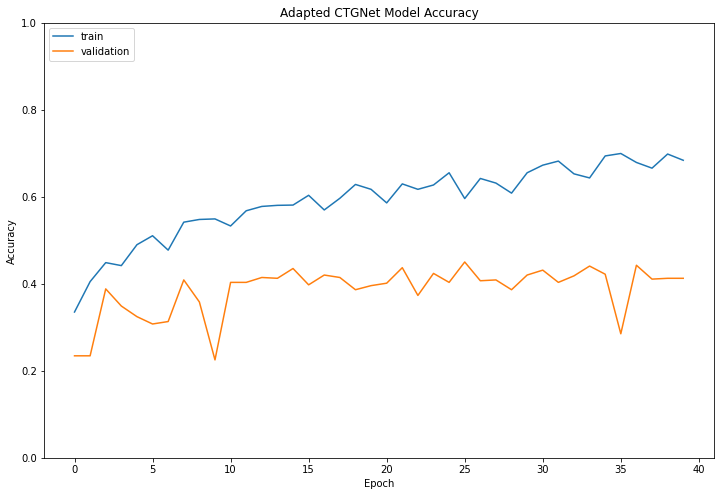

In [36]:
plot_hist(histories[3])

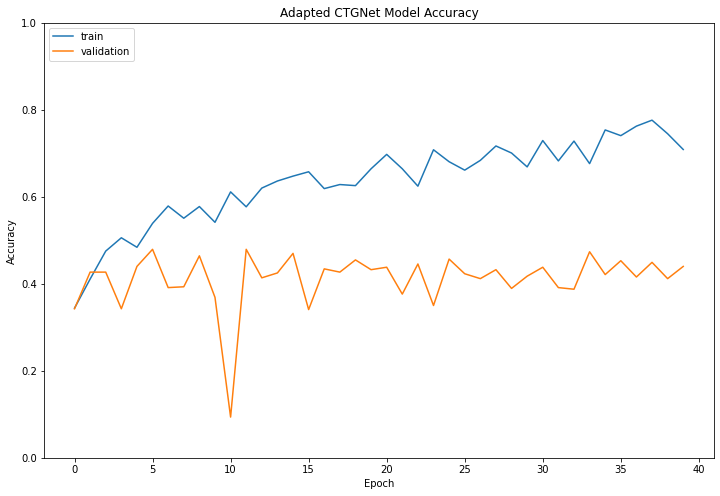

In [37]:
# plot the accuracies and epochs
plot_hist(histories[4])

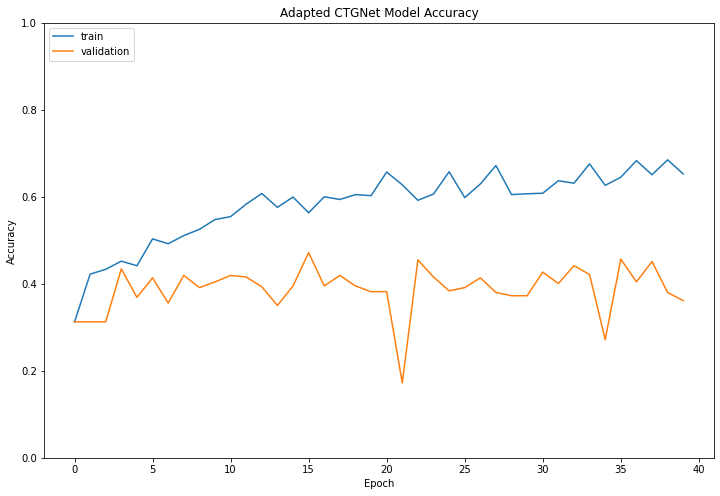

In [38]:
plot_hist(histories[5])

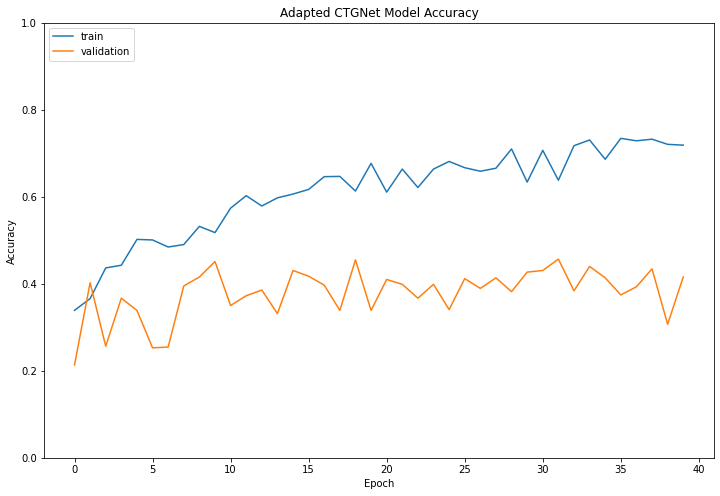

In [39]:
plot_hist(histories[6])

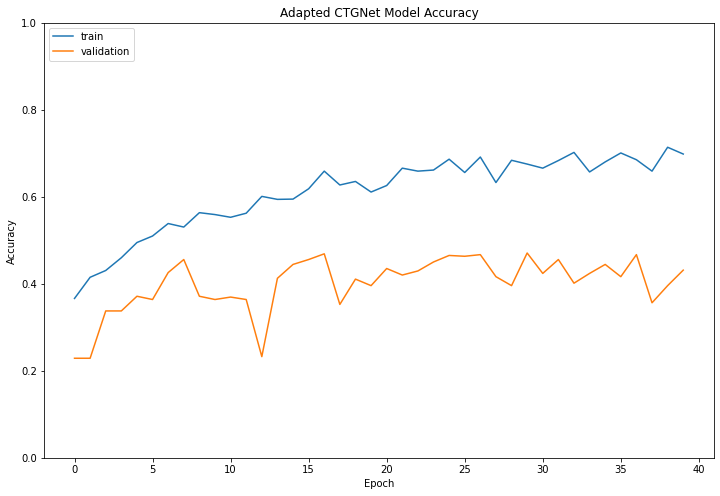

In [40]:
plot_hist(histories[7])

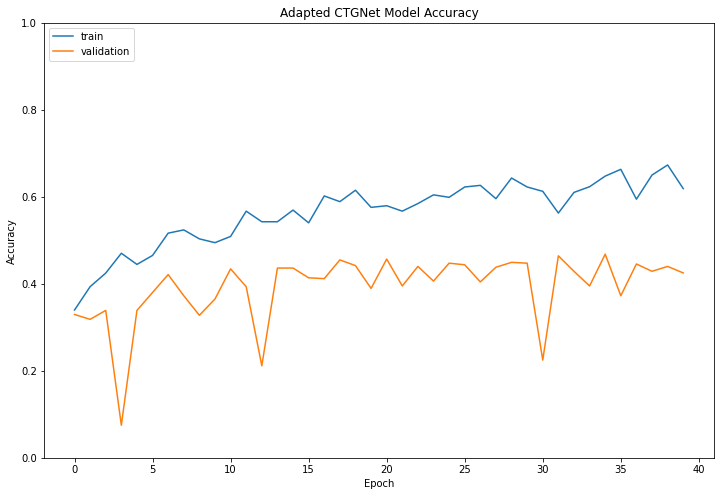

In [41]:
plot_hist(histories[8])

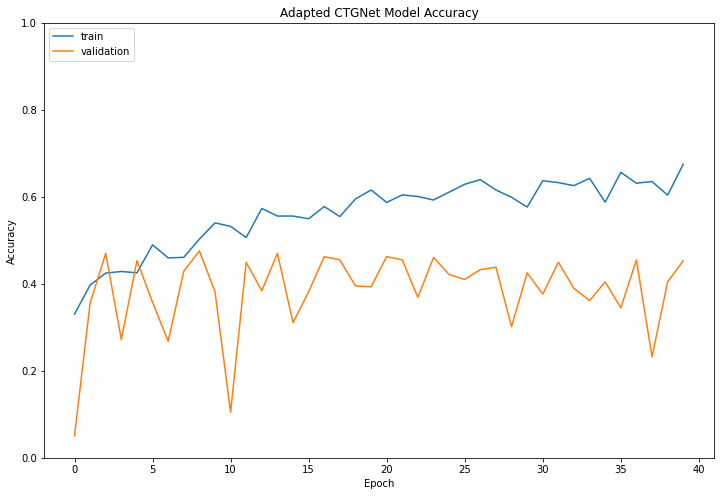

In [42]:
plot_hist(histories[9])

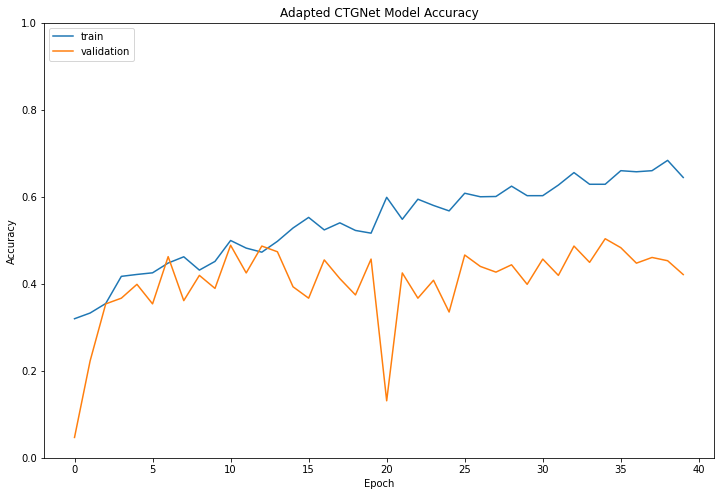

In [43]:
plot_hist(histories[10])

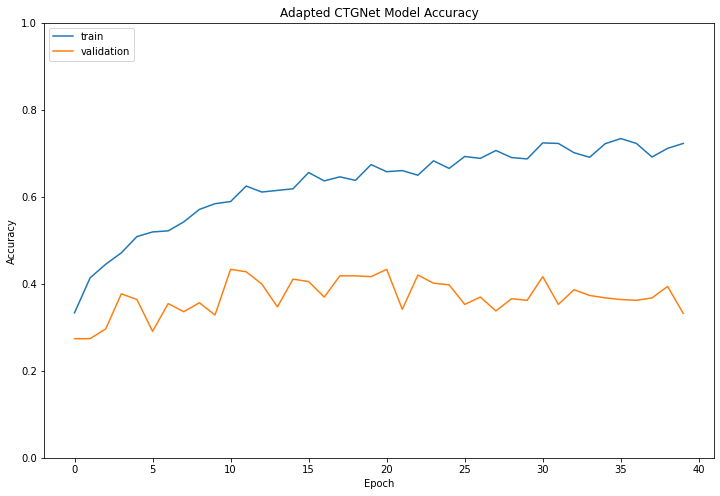

In [44]:
plot_hist(histories[11])

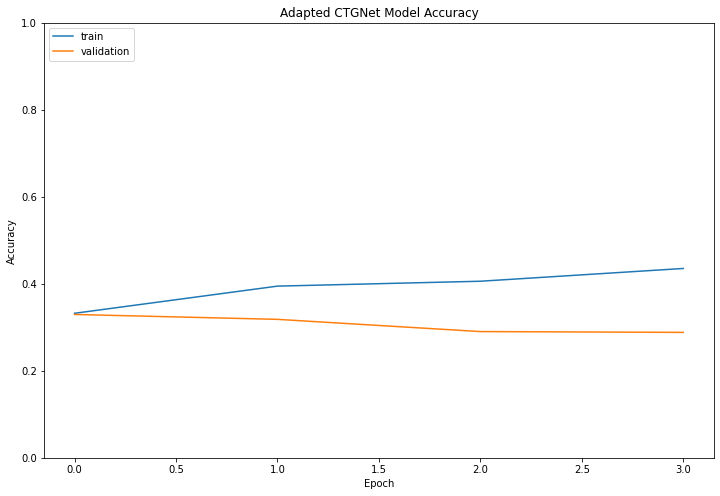

In [45]:
plot_hist(histories[12])

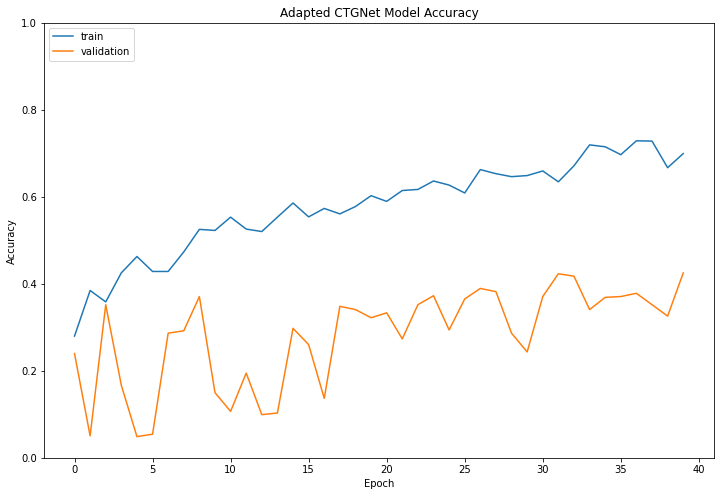

In [46]:
plot_hist(histories[13])

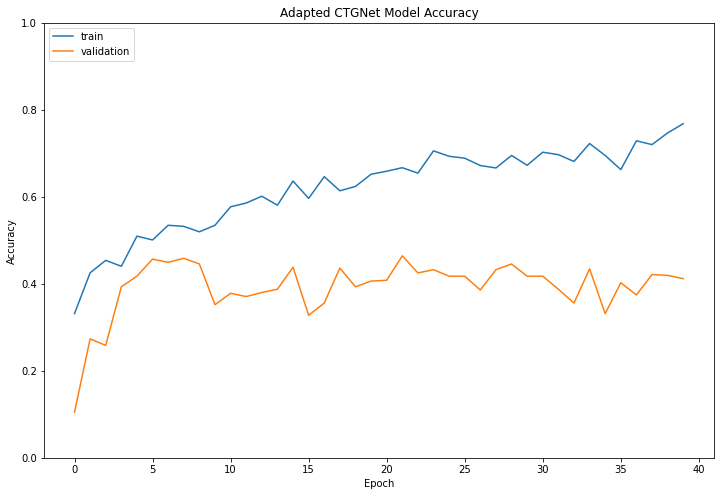

In [47]:
plot_hist(histories[14])

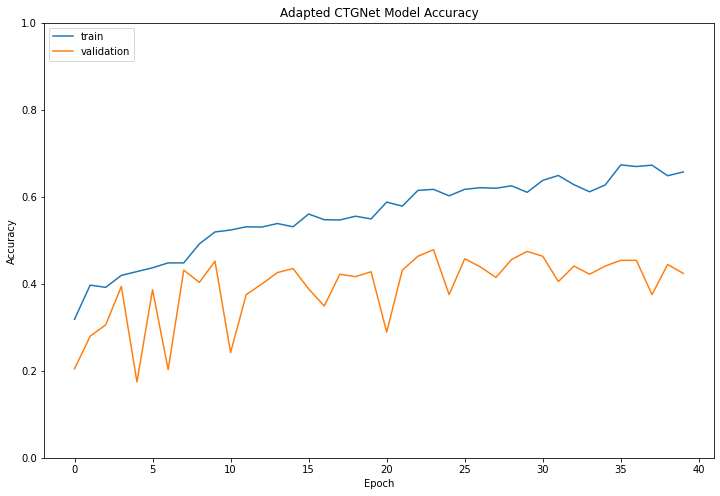

In [48]:
plot_hist(histories[15])

## Choose the best performing fold as Best Model for Confusion Matrix

In [50]:
# chose the best performing model to show confusion matrix
best_model = models[3]

In [51]:
# save best model
best_model.save('CTG_model_best_crossValidated')

INFO:tensorflow:Assets written to: CTG_model_best_crossValidated/assets


In [54]:
# evaluate model on holdout_ds
best_model.evaluate(holdout_ds)

9/9 [==============================] - 0s 10ms/step - loss: 9.8315 - sparse_categorical_accuracy: 0.4829


[9.831480979919434, 0.48288974165916443]

In [55]:
predictions = np.array([])
labels =  np.array([])
for x, y in holdout_ds:
    predictions = np.concatenate([predictions, np.argmax(best_model.predict(x), axis=-1)])
    labels = np.concatenate([labels, (y.numpy())])

In [56]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve, auc
from sklearn.preprocessing import label_binarize

# print classification report from sklearn
print(classification_report(labels, predictions, target_names=class_names))

              precision    recall  f1-score   support

         ACC       0.38      0.48      0.43        52
   DEC_EARLY       0.56      0.49      0.52        97
    DEC_LATE       0.00      0.00      0.00        22
     DEC_VAR       0.00      0.00      0.00        11
        NONE       0.49      0.67      0.57        81

    accuracy                           0.48       263
   macro avg       0.29      0.33      0.30       263
weighted avg       0.43      0.48      0.45       263



/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


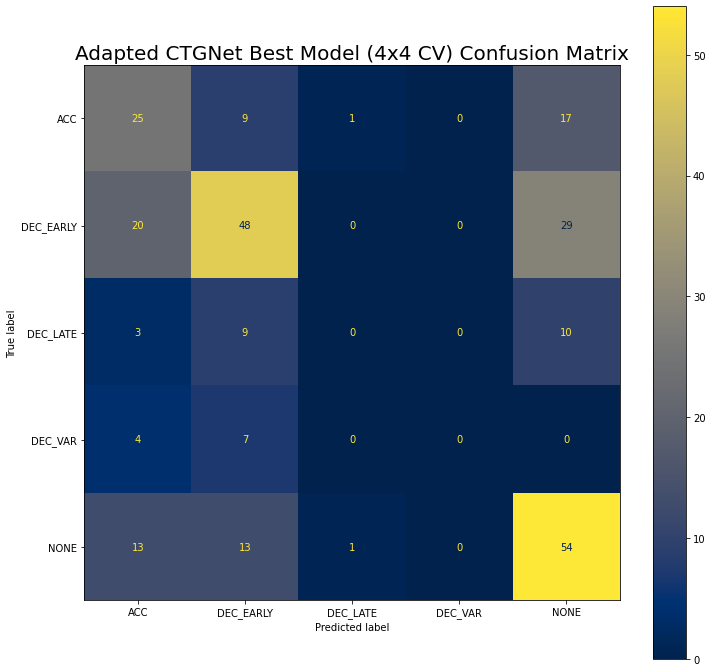

In [58]:
# plot the confusion matrix
fig, ax = plt.subplots(figsize=(12,12))
ax.set_title("Adapted CTGNet Best Model (4x4 CV) Confusion Matrix", fontsize = 20)
disp = metrics.ConfusionMatrixDisplay.from_predictions(labels, predictions, display_labels=class_names, cmap='cividis', ax=ax)